In [58]:
from tqdm import tqdm
import numpy as np

import medmnist 
from medmnist import BreastMNIST
from medmnist import INFO, Evaluator

import os
import cv2

#Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [59]:
# Navigate to the dataset file
npz_file_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), 'Datasets', 'breastmnist.npz')

# Step 4: Load the breastmnist.npz file using numpy
data = np.load(npz_file_path)

# Print the names of arrays stored in the .npz file
print("Stored arrays:", data.files)

for item in data.files:
    print(item)
    print(data[item].shape)

train_dataset = data['train_images']
print('Training dataset', train_dataset.shape)

val_dataset = data['val_images']
print('Validation dataset', val_dataset.shape)

test_dataset = data['test_images']
print('Testing dataset', test_dataset.shape)

y_train_labels = data['train_labels']
print('Training label', y_train_labels.shape)


y_val_labels = data['val_labels']
print('Validation label', y_val_labels.shape)

y_test_labels = data['test_labels']
print('Testing label', y_test_labels.shape)

Stored arrays: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
train_images
(546, 28, 28)
val_images
(78, 28, 28)
test_images
(156, 28, 28)
train_labels
(546, 1)
val_labels
(78, 1)
test_labels
(156, 1)
Training dataset (546, 28, 28)
Validation dataset (78, 28, 28)
Testing dataset (156, 28, 28)
Training label (546, 1)
Validation label (78, 1)
Testing label (156, 1)


In [60]:
#print("Malignant:",train_dataset[4])
#print("Malignant:",train_dataset[4][0][1])

train = np.empty((train_dataset.shape))
#Normalise train

train = train_dataset/ 255
print(train.shape)
            #print(train_dataset[img][row][column])
            
#print("Malignant:",train_dataset[4][0][1])

(546, 28, 28)


In [3]:
x_train = torch.FloatTensor(train_dataset)
x_val = torch.FloatTensor(val_dataset)
x_test = torch.FloatTensor(test_dataset)
y_train = torch.FloatTensor(y_train_labels)
y_val = torch.FloatTensor(y_val_labels)
y_test = torch.FloatTensor(y_test_labels)

print(x_train[0], y_train)

tensor([[139., 139., 138., 139., 142., 149., 156., 159., 164., 167., 168., 163.,
         166., 169., 164., 166., 162., 158., 164., 156., 156., 165., 161., 154.,
         156., 165., 162., 165.],
        [ 84.,  92.,  94.,  84.,  84.,  86.,  94., 109., 129., 135., 131., 130.,
         136., 125., 111., 119., 117., 121., 131., 117., 132., 133., 133., 139.,
         140., 124., 116., 112.],
        [ 84.,  82.,  87., 101., 101.,  96.,  90.,  95., 106.,  97.,  86.,  97.,
         116., 107.,  91.,  86.,  77.,  91., 128., 129., 129., 130., 136., 136.,
         128., 124., 127., 126.],
        [ 83.,  77.,  95., 120., 107.,  76.,  93.,  96., 106., 114., 111., 109.,
          97.,  83.,  72.,  71.,  65.,  74.,  99., 110., 122., 133., 111., 110.,
         122., 134., 143., 149.],
        [ 76.,  73.,  89.,  94.,  89.,  79.,  73.,  74.,  83., 109., 110., 119.,
         110., 103.,  83.,  75.,  71.,  77.,  88.,  97., 117., 122., 120., 119.,
         134., 132., 131., 128.],
        [ 80.,  77.,

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,32,5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,32,5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 1, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
        )
        self.classifier = nn.Linear(9, 1)
    def forward(self,input):
        out1 = self.conv1(input)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        output = self.classifier(torch.reshape(out3, (-1, 9))).squeeze()
        output = torch.sigmoid(output)
        return output
    
# Optimizer
net = CNN()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.003)  # lr = learning rate

In [5]:
# Store Weights
losses = []
val_accuracies = []

# Training 10000 epochs
for epoch in range(10000):
    optimizer.zero_grad()
    outputs = net(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        val_outputs = net(x_val)
        predicted = torch.where(val_outputs > 0.5, 1, 0)
        accuracy = accuracy_score(y_val, predicted)
        val_accuracies.append(accuracy)

    losses.append(loss.item())

# Testing
with torch.no_grad():
    test_outputs = net(x_test)
    predicted = torch.where(test_outputs > 0.5, 1, 0)
    test_accuracy = accuracy_score(y_test, predicted)
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plot epoch loss and accuracy graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')

plt.show()

RuntimeError: Given groups=1, weight of size [32, 1, 5, 5], expected input[1, 546, 28, 28] to have 1 channels, but got 546 channels instead

In [105]:

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [167]:
#data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [168]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Catherine\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\Catherine\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\Catherine\.medmnist\breastmnist.npz


In [169]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: C:\Users\Catherine\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\Catherine\.medmnist
    Split: test
    Task: binary-class
    Number of channels:

In [170]:
train_dataset.montage(length=1)

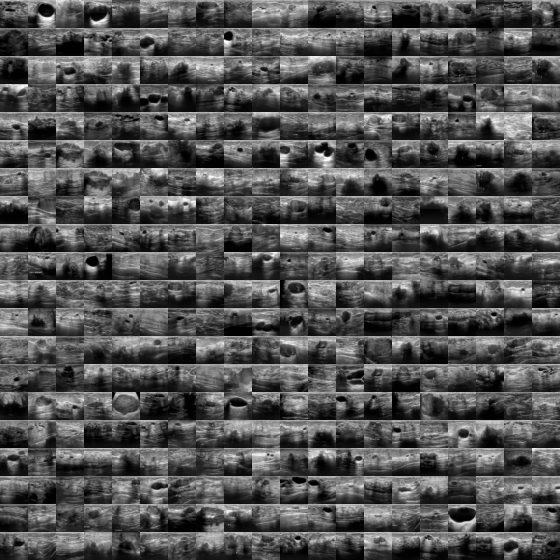

In [171]:
# montage

train_dataset.montage(length=20)

In [173]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [174]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 18/18 [00:00<00:00, 115.23it/s]


In [175]:

# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 1.000  acc:1.000
test  auc: 0.885  acc:0.846
